In [38]:
import numpy as np
from pathlib import Path
import sys

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

In [2]:
ROOT_PATH = Path.cwd().parent
DATA_PATH = ROOT_PATH / "data"
sys.path.append(ROOT_PATH.as_posix())

VAL_SIZE = 0.8
BATCH_SIZE = 32

image_size = 256
crop_scale = (0.10, 1)
p_augment = 0.5 

In [3]:
from src.data import LeafDataset

In [4]:
aug = A.Compose([
    A.RandomResizedCrop(
        height = image_size, 
        width = image_size,
        scale = crop_scale,
    ),
    A.RandomGridShuffle(
        p = p_augment,
        grid = (3, 3),
    ),
    A.Transpose(p = 0.5),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p   = 0.5),
    A.ShiftScaleRotate(
        p = p_augment,
        shift_limit  = 0.05,
        scale_limit  = 0.05,
        rotate_limit = 360,
    ),
    A.HueSaturationValue(
        p = p_augment,
        hue_shift_limit = 20,
        sat_shift_limit = 20,
        val_shift_limit = 20,
    ),
    A.RandomBrightnessContrast(
        p = p_augment,
        brightness_limit = 0.1,
        contrast_limit   = 0.1,
    ),
    A.CLAHE(
        p = p_augment,
        clip_limit = 0,
        tile_grid_size = (1, 1)
    ),
    A.OneOf(
        [
            A.MotionBlur(blur_limit = 3),
            A.MedianBlur(blur_limit = 3),
            A.GaussianBlur(blur_limit = 3)
            ], 
        p = p_augment
    ),
    A.OneOf(
        [
            A.OpticalDistortion(distort_limit = 0.1),
            A.GridDistortion(distort_limit = 0.1)
        ], 
        p = p_augment
    ),
    A.Cutout(
        p = p_augment,
        num_holes = 5, 
        max_h_size = int(0.1 * image_size),
        max_w_size = int(0.1 * image_size)
    ),
    A.Normalize(mean = (0, 0, 0), std = (1, 1, 1)),
    ToTensorV2()
])

/Users/philippmoehl/anaconda3/envs/plants/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/Users/philippmoehl/anaconda3/envs/plants/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [32]:
dataset = LeafDataset(DATA_PATH)

In [36]:
# Split the dataset into training and validation sets (e.g., 80% train, 20% validation)
train_size = int(VAL_SIZE * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# add transformations
train_dataset.dataset.transform = aug

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [41]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

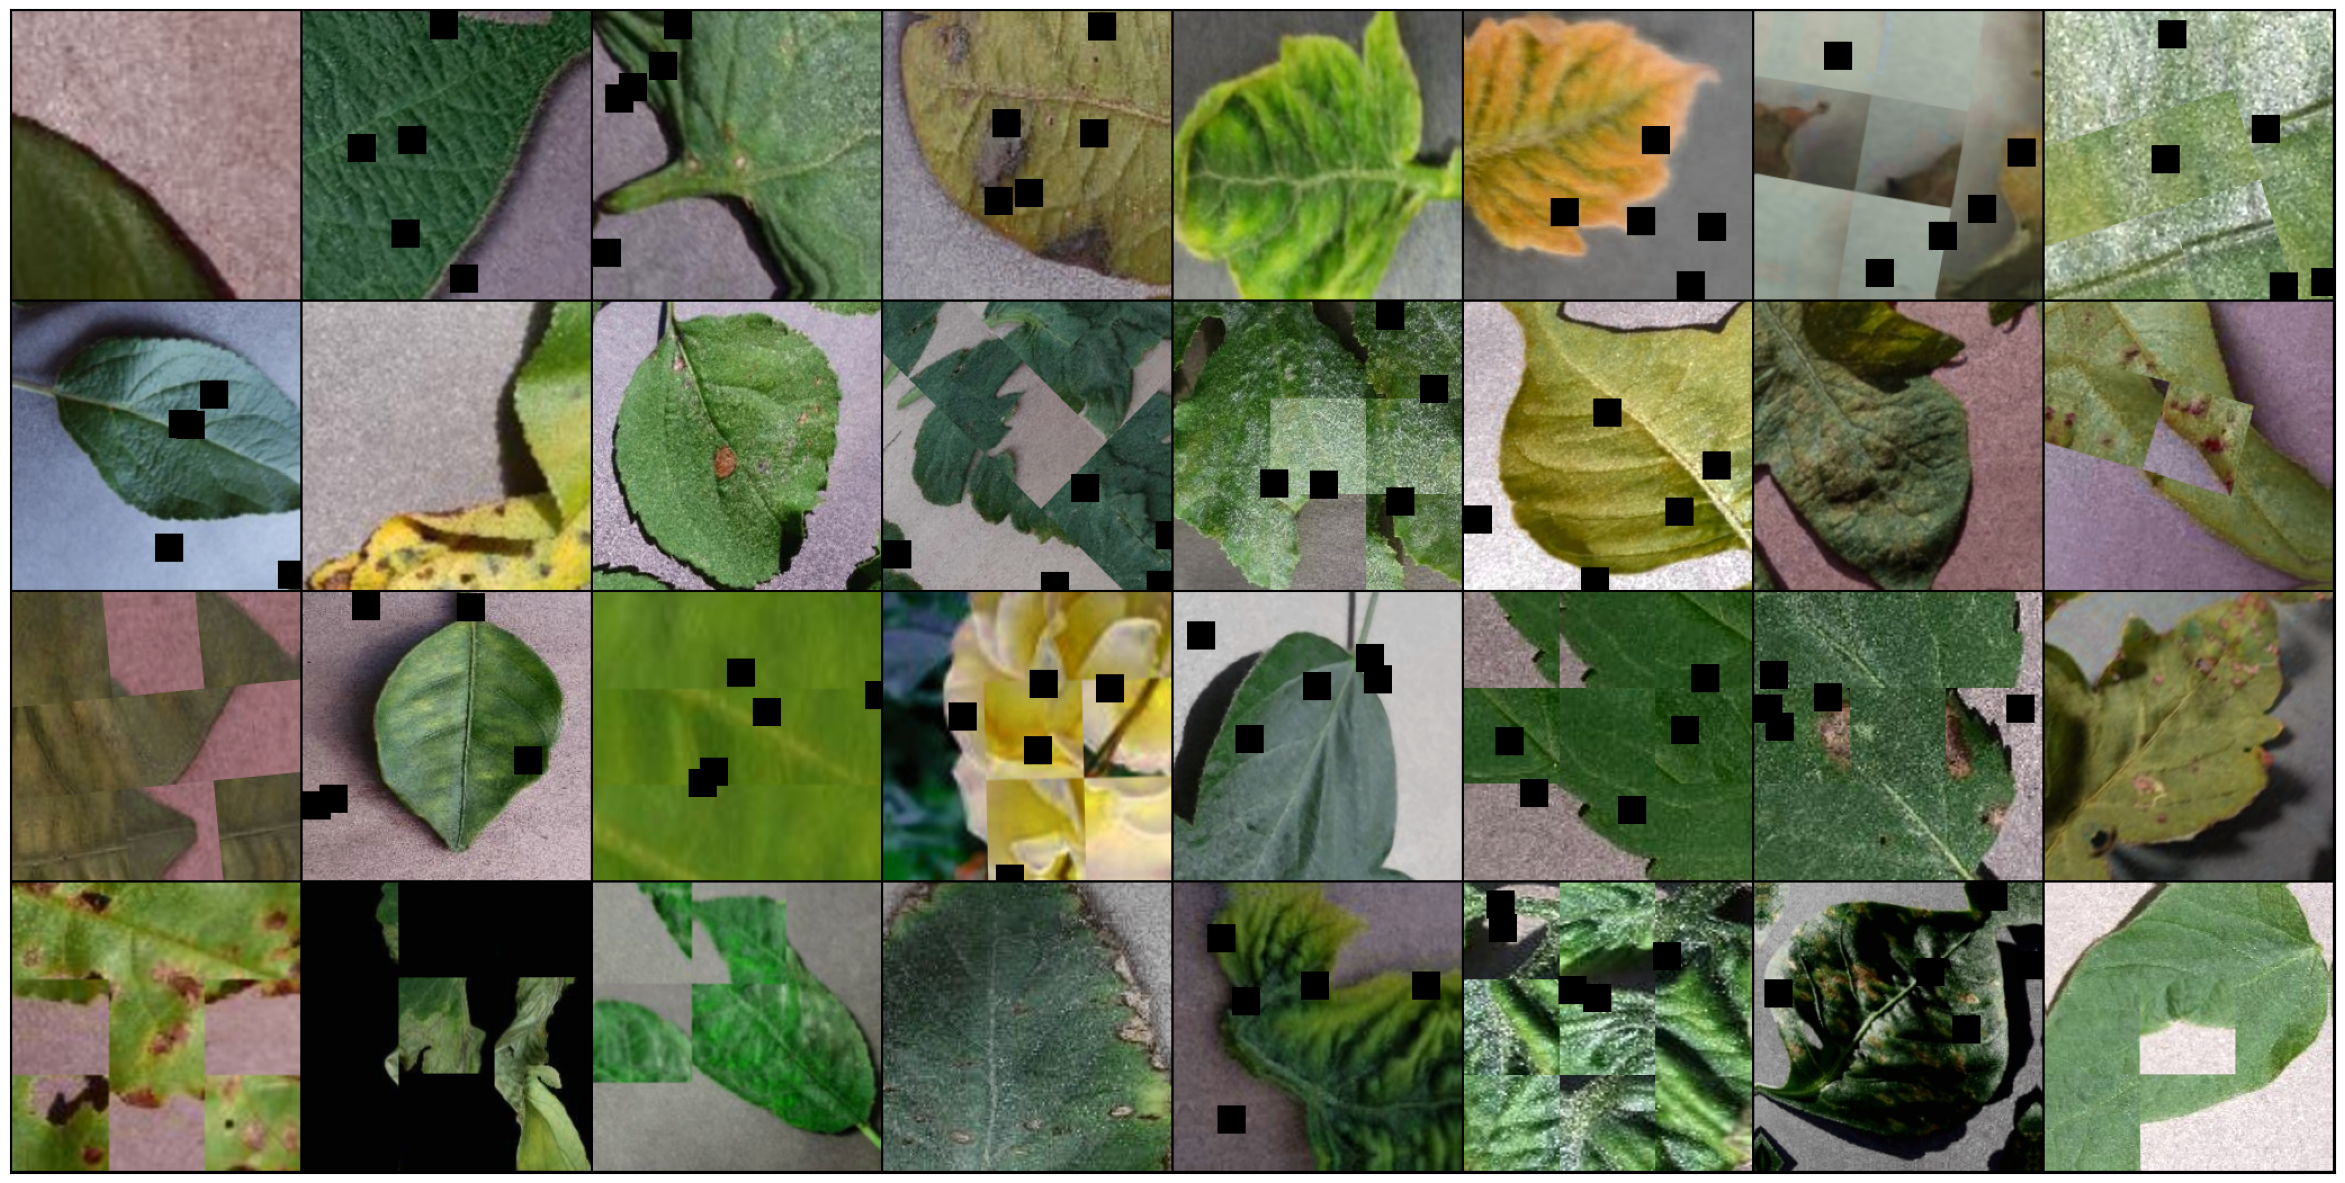

In [42]:
show_batch(train_loader) 

In [ ]:
####### AUGMENTATIONS

def get_augs(CFG, image_size = None, p_augment = None):
    
    '''
    Get train and test augmentations
    '''

    # update epoch-based parameters
    if image_size is None:
        image_size = CFG['image_size']
    if p_augment is None:
        p_augment = CFG['p_augment']
        
    # tests
    assert isinstance(CFG, dict), 'CFG has to be a dict with parameters'
    assert 0 <= p_augment <= 1,   'p_aug has to be between 0 and 1'
    assert image_size > 0,        'image_size has to be positive'

    # normalization
    if CFG['normalize']:
        if CFG['normalize'] == 'imagenet':
            CFG['pixel_mean'] = (0.485, 0.456, 0.406)
            CFG['pixels_std'] = (0.229, 0.224, 0.225)
        elif CFG['normalize'] == 'custom':
            CFG['pixel_mean'] = (0.442, 0.511, 0.318)
            CFG['pixels_std'] = (0.233, 0.236, 0.225)
    else:
        CFG['pixel_mean'] = (0, 0, 0)
        CFG['pixels_std'] = (1, 1, 1)

    # train augmentations
    train_augs = A.Compose([A.RandomResizedCrop(height = image_size, 
                                                width  = image_size,
                                                scale  = CFG['crop_scale']),
                            A.RandomGridShuffle(p    = p_augment,
                                              grid = CFG['gr_shuffle']),
                            A.Transpose(p      = 0.5),
                            A.HorizontalFlip(p = 0.5),
                            A.VerticalFlip(p   = 0.5),
                            A.ShiftScaleRotate(p            = p_augment,
                                               shift_limit  = CFG['ssr'][0],
                                               scale_limit  = CFG['ssr'][1],
                                               rotate_limit = CFG['ssr'][2]),
                            A.HueSaturationValue(p               = p_augment,
                                                 hue_shift_limit = CFG['huesat'][0],
                                                 sat_shift_limit = CFG['huesat'][1],
                                                 val_shift_limit = CFG['huesat'][2]),
                            A.RandomBrightnessContrast(p                = p_augment,
                                                       brightness_limit = CFG['bricon'][0],
                                                       contrast_limit   = CFG['bricon'][1]),
                            A.CLAHE(p              = p_augment,
                                    clip_limit     = CFG['clahe'][0],
                                    tile_grid_size = (CFG['clahe'][1], CFG['clahe'][1])),
                            A.OneOf([A.MotionBlur(blur_limit   = CFG['blur_limit']),
                                     A.MedianBlur(blur_limit   = CFG['blur_limit']),
                                     A.GaussianBlur(blur_limit = CFG['blur_limit'])], 
                                     p = p_augment),
                            A.OneOf([A.OpticalDistortion(distort_limit = CFG['dist_limit']),
                                     A.GridDistortion(distort_limit    = CFG['dist_limit'])], 
                                     p = p_augment),
                            A.Cutout(p          = p_augment, 
                                     num_holes  = CFG['cutout'][0], 
                                     max_h_size = np.int(CFG['cutout'][1] * image_size), 
                                     max_w_size = np.int(CFG['cutout'][1] * image_size)),
                            A.Normalize(mean = CFG['pixel_mean'],
                                        std  = CFG['pixels_std']),
                            ToTensorV2()
                           ])

    # test augmentations
    test_augs = A.Compose([A.SmallestMaxSize(max_size = image_size),
                           A.CenterCrop(height = image_size, 
                                        width  = image_size),
                           A.Normalize(mean = CFG['pixel_mean'],
                                       std  = CFG['pixels_std']),
                           ToTensorV2()
                           ])
    
    # output
    return train_augs, test_augs



####### CUTMIX

def rand_bbox(size, lam):

    W = size[2]
    H = size[3]

    cut_rat = np.sqrt(1. - lam)
    cut_w   = np.int(W * cut_rat)
    cut_h   = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix_fn(data, target, alpha):

    indices         = torch.randperm(data.size(0))
    shuffled_data   = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets



####### TTA HELPER FUNCTION

'''
Boorowed from https://github.com/haqishen/SIIM-ISIC-Melanoma-Classification-1st-Place-Solution
'''

def get_tta_flips(img, i):

    if i >= 4:
        img = img.transpose(2, 3)
    if i % 4 == 0:
        return img
    elif i % 4 == 1:
        return img.flip(2)
    elif i % 4 == 2:
        return img.flip(3)
    elif i % 4 == 3:
        return img.flip(2).flip(3)